<a href="https://colab.research.google.com/github/gdnsjf/Check-Cosmetics-tg-bot/blob/main/YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Решите пожалуйста следующую задачу.
Возьмите произвольную фотографию из интернета с большим количество объектов на фото.
Примените YOLO алгоритм для обнаружения объектов на фото

In [ ]:
# установка ultralytics для использования моделей семейства YOLO
!pip install -qq ultralytics


image 1/1 /content/INFUZE_GROUP_SHOT.jpg: 320x640 10 persons, 2 bicycles, 3 cars, 147.6ms
Speed: 2.7ms preprocess, 147.6ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 640)


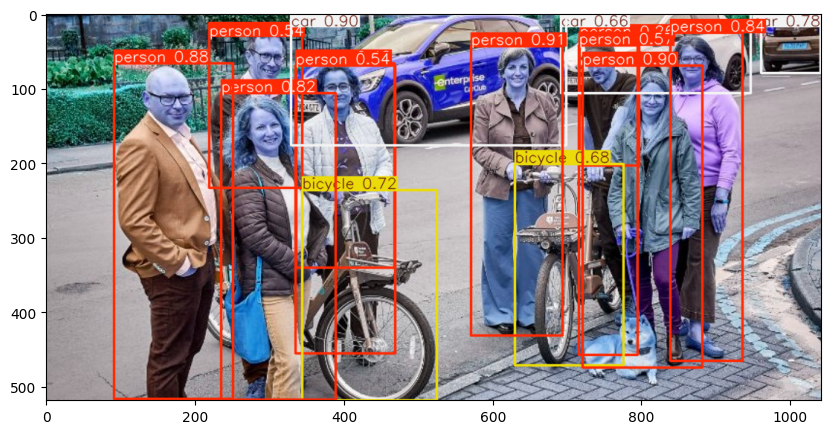

In [ ]:
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Загружаем предобученную модель YOLOv8
model = YOLO("yolov8n.pt")

# Путь до изображения
image_path = "/content/INFUZE_GROUP_SHOT.jpg"

# Выполняем детекцию объектов на изображении
results = model(image_path)

# Отображаем результат
plt.figure(figsize=(10, 10))
plt.imshow(results[0].plot())
plt.show()